# INTRODUCTION

In this notebook, I present my attempt at speech-based gender classification using the LibriSpeech dev-clean corpus.

The major contribution of the procedure applied in this notebook is the feature engineering which provides dimensionality reduction and qualitative modeling input. The speech classification is performed by the methodology below:

**load data ===> Features Extraction, transformation and preparation ===> Modeling**.

The features (engineering) extraction is based on a summarized version of the MFCC feature space. Specifically, I show that by obtaining just the 6 MFCC features and summarizing them into into their mean and standard deviation, and concatenating these faetures for each data, it is possible to train a simple classifier like k-Nearest Neighbor (KNN) and achieve 94% accuracy.

In addition to KNN, other classifier models which I have applied here are Naive Bayes, Random Forest, feed forward neural network and 1D convolutional neural network. 

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load clean data

In [169]:
SPEECH_DATA_PATH = 'LibriSpeech/'
RANDOM_SEED = 42

Load .txt file containing metadata each speaker ID and Gender/sex. This file is used to map the IDs to the gender/sex

In [175]:
speakers = pd.read_csv(SPEECH_DATA_PATH + 'SPEAKERS.TXT', comment=';', sep ='|', 
                       header = None, error_bad_lines=False, dtype ='string')


speakers.columns = ['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'] #Defines column names



speakers.SEX = speakers.SEX.str.strip()
speakers.SUBSET = speakers.SUBSET.str.strip()


speakers.dtypes

b'Skipping line 45: expected 5 fields, saw 7\n'


ID         string
SEX        string
SUBSET     string
MINUTES    string
NAME       string
dtype: object

###### Integer encoding for categorical data: Male = 0, Female = 1

In [176]:
speakers['SEX'].replace('M', 0, inplace=True)
speakers['SEX'].replace('F', 1, inplace=True)

In [177]:
speakers = speakers.astype({'MINUTES': 'float64', 'ID': 'int32', 'SEX': 'int32'})
#speakers[speakers.columns] = speakers.apply(lambda x: x.str.strip())
speakers.dtypes

ID           int32
SEX          int32
SUBSET      string
MINUTES    float64
NAME        string
dtype: object

In [178]:
speakers.head(10)

,ID,SEX,SUBSET,MINUTES,NAME
0,14,1,train-clean-360,25.03,Kristin LeMoine
1,16,1,train-clean-360,25.11,Alys AtteWater
2,17,0,train-clean-360,25.04,Gord Mackenzie
3,19,1,train-clean-100,25.19,Kara Shallenberg
4,20,1,train-other-500,30.07,Gesine
5,22,1,train-clean-360,25.14,Michelle Crandall
6,23,1,train-clean-360,25.23,Anita Roy Dobbs
7,25,0,train-other-500,30.16,John Gonzalez
8,26,0,train-clean-100,25.08,Denny Sayers
9,27,0,train-clean-100,20.14,Sean McKinley


In [179]:
print(f'The whole data has {speakers.shape[0]} rows and {speakers.shape[1]} columns' )

The whole data has 2483 rows and 5 columns


###### Select the `dev-clean` data out of all the data


In [180]:
subset_length = 20     # 20 per gender
subset_speakers = speakers[speakers.SUBSET == 'dev-clean']
subset_speakers = subset_speakers.groupby('SEX', group_keys=False).apply(lambda x: x.sample(subset_length)).reset_index(drop =True)
print(f'Total amount of training data is: {subset_speakers.shape[0]}')
print(f' Number of MALES in full training data is: ', subset_speakers[subset_speakers.SEX == 0].shape[0])
print(f' Number of FEMALES in full training data is: ', subset_speakers[subset_speakers.SEX == 1].shape[0])
subset_speakers.head(20)                                                                    

Total amount of training data is: 40
 Number of MALES in full training data is:  20
 Number of FEMALES in full training data is:  20


,ID,SEX,SUBSET,MINUTES,NAME
0,3170,0,dev-clean,8.10,VOICEGUY
1,2803,0,dev-clean,8.20,aquielisunari
2,174,0,dev-clean,8.04,Peter Eastman
3,652,0,dev-clean,8.31,Scott Walter
4,3000,0,dev-clean,8.03,Brian von Dedenroth
5,6241,0,dev-clean,8.05,badey
6,6295,0,dev-clean,8.04,Michael Packard
7,2428,0,dev-clean,8.02,Stephen Kinford
8,1272,0,dev-clean,8.02,John Rose
9,777,0,dev-clean,8.06,fling93


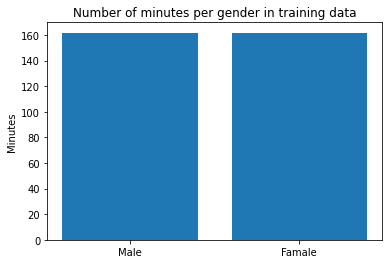

In [181]:
#np.random.seed(RANDOM_SEED)

sex_plot = ['Male', 'Famale']
minuites_per_gender = [subset_speakers[subset_speakers.SEX==0].MINUTES.sum(),
                       subset_speakers[subset_speakers.SEX==1].MINUTES.sum()]



plt.bar(sex_plot , minuites_per_gender )
plt.title('Number of minutes per gender in training data')
plt.ylabel('Minutes')
plt.show()

##### Select only 'ID' and 'SEX' columns for further processes

In [182]:
subset_speakers = subset_speakers[['ID','SEX']]

# VISUAL INSPECTION FOR FEATURE ENGINEERING

Here, the goal is to visually inspect some of the files and their corresponding MFCC features. The isnpection is done per gender in order to see if it is possible to find visual differences in the signals produced by different genders.

The process followed for this section is outlined below:
1. Select two speakers each for male and female and visualize their raw and MFCC spectra. 
1. For Male gender, I selected speaker IDs: **3000 (Male 1), 6295 (Male 2)**. 
1. For females, I selected Speaker IDs: **2035 (Female 1), 6319 (Female 2)**. 

**This is an insufficient amount of samples to visualize, but should pass for this small task**

For me to obtain the MFCC transform of the raw signals, I must select the `number of features` (i.e feature vector size). For this, I have selected 14 based on the results published [***HERE**](https://ieeexplore.ieee.org/document/647282) 

In [183]:
import librosa

no_of_mfcc_features = 14 

In [184]:
sample_male1_file_path = SPEECH_DATA_PATH + '/dev-clean/3000/15664/3000-15664-0000.flac'
male1_audio, sr = librosa.load(sample_male1_file_path ,mono= True)
male1_audio_mfcc_feature = librosa.feature.mfcc(male1_audio, n_mfcc= no_of_mfcc_features)

sample_male2_file_path = SPEECH_DATA_PATH + '/dev-clean/6295/64301/6295-64301-0000.flac'
male2_audio, sr = librosa.load(sample_male2_file_path ,mono= True)
male2_audio_mfcc_feature = librosa.feature.mfcc(male2_audio, n_mfcc= no_of_mfcc_features)

print('Shape of the MFCC feature for Sample Male 1 is: ', male1_audio_mfcc_feature.shape)
print('Shape of the MFCC feature for Sample Male 2 is: ', male2_audio_mfcc_feature.shape)

Shape of the MFCC feature for Sample Male 1 is:  (14, 135)
Shape of the MFCC feature for Sample Male 2 is:  (14, 761)


The cell below plots the raw, mfcc and binned sum of standard deviation of the mfcc features (binned into features [0 - 5] and [6 - 14]. The binned sum of standard deviation helps to emphsize the difference in variability between MFCC feature 0 - 5 and 5 - 14.

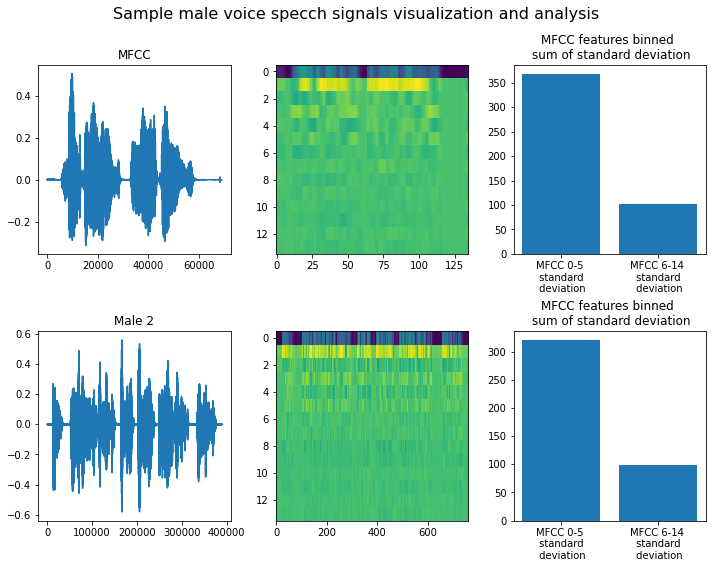

In [185]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10,8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

fig.suptitle('Sample male voice specch signals visualization and analysis', fontsize=16)
#======================================================SAMPLE MALE 1=============================================
ax1.plot(male1_audio)
ax1.set_title("Raw")
ax2.imshow(male1_audio_mfcc_feature, interpolation='nearest', aspect='auto')
ax1.set_title("MFCC")
ax3.bar(['MFCC 0-5 \n standard \n deviation', 'MFCC 6-14 \n standard \n deviation'],
        [np.sum(np.std(male1_audio_mfcc_feature[:6,:], axis = 1)),  
         np.sum(np.std(male1_audio_mfcc_feature[6:,:], axis = 1))])
ax3.set_title('MFCC features binned \n sum of standard deviation')

#======================================================SAMPLE MALE 2=============================================

ax4.plot(male2_audio)
ax4.set_title("Male 2")
ax5.imshow(male2_audio_mfcc_feature, interpolation='nearest', aspect='auto')
ax6.bar(['MFCC 0-5 \n standard \n deviation', 'MFCC 6-14 \n standard \n deviation'],
        [np.sum(np.std(male2_audio_mfcc_feature[:6,:], axis = 1)),  
         np.sum(np.std(male2_audio_mfcc_feature[6:,:], axis = 1))])
ax6.set_title('MFCC features binned \n sum of standard deviation')
plt.tight_layout()

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [186]:
sample_female1_file_path = SPEECH_DATA_PATH + '/dev-clean/2035/147960/2035-147960-0000.flac'
female1_audio, sr = librosa.load(sample_female1_file_path ,mono= True)
female1_audio_mfcc_feature = librosa.feature.mfcc(female1_audio, n_mfcc= no_of_mfcc_features)

sample_female2_file_path = SPEECH_DATA_PATH + '/dev-clean/6319/57405/6319-57405-0000.flac'
female2_audio, sr = librosa.load(sample_female2_file_path ,mono= True)
female2_audio_mfcc_feature = librosa.feature.mfcc(female2_audio, n_mfcc= no_of_mfcc_features)

print('Shape of the MFCC feature for Samle Female 1 is: ', female1_audio_mfcc_feature.shape)
print('Shape of the MFCC feature for Samle Female 2 is: ', female2_audio_mfcc_feature.shape)

Shape of the MFCC feature for Samle Female 1 is:  (14, 389)
Shape of the MFCC feature for Samle Female 2 is:  (14, 315)


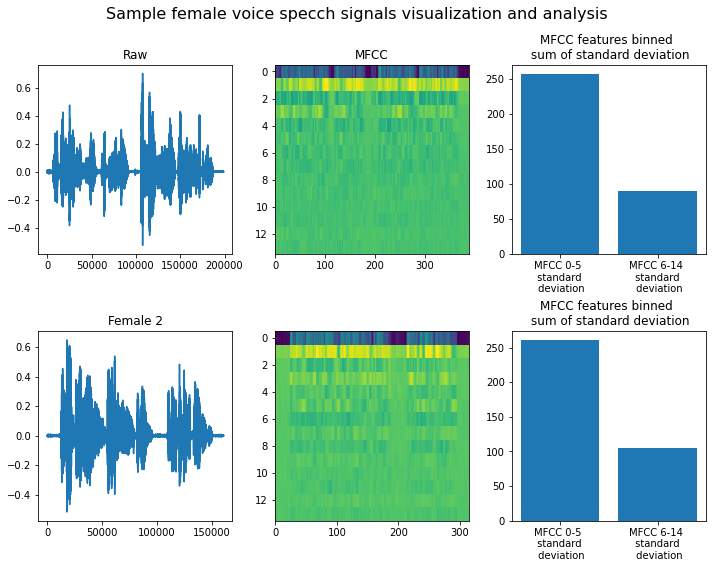

In [187]:
fig, axes = plt.subplots(nrows= 2, ncols= 3, figsize= (10,8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

fig.suptitle('Sample female voice specch signals visualization and analysis', fontsize=16)
#======================================================SAMPLE FEMALE 1=============================================
ax1.plot(female1_audio)
ax1.set_title("Raw")
ax2.imshow(female1_audio_mfcc_feature, interpolation='nearest', aspect='auto')
ax2.set_title("MFCC")
ax3.bar(['MFCC 0-5 \n standard \n deviation', 'MFCC 6-14 \n standard \n deviation'],
        [np.sum(np.std(female1_audio_mfcc_feature[:6,:], axis = 1)),  
         np.sum(np.std(female1_audio_mfcc_feature[6:,:], axis = 1))])
ax3.set_title('MFCC features binned \n sum of standard deviation')

#======================================================SAMPLE FEMALE 2=============================================

ax4.plot(female2_audio)
ax4.set_title("Female 2")
ax5.imshow(female2_audio_mfcc_feature, interpolation='nearest', aspect='auto')
ax6.bar(['MFCC 0-5 \n standard \n deviation', 'MFCC 6-14 \n standard \n deviation'],
        [np.sum(np.std(female2_audio_mfcc_feature[:6,:], axis = 1)),  
         np.sum(np.std(female2_audio_mfcc_feature[6:,:], axis = 1))])
ax6.set_title('MFCC features binned \n sum of standard deviation')
fig.tight_layout()
fig.subplots_adjust(top=0.88)

The following points visualisation, are noted:
 1. The first 6 MFCC features (0 - 5) capture the most variability. Since entropy is information, I thus proceed with the hypothesis that most of the information in the signals are captured in the first 6 MFCC features. I select these 6 and discard the rest.
 1. There are no visual differences across gender from on the frames visualised.
 1. The features are on of the same size for different audio files because the duration of the files are the equal. Since a typical machine learning model requires a defines inout size, there is the need to resample the data in such a way that all resulting features are equal. There are a few ways to go about this, each one with its own advantages. Some of the possible approaches are: 
     - cropping: most applicable if we know high density time region in most of the audio files
     - Truncation: can lead to sparsity if many files have cold start (i.e sparsity at the beginning)
     - Zero padding: works best when the differences sizes are not large. In cases where some frames are twice as long as others, this can lead to sparsity in certain padded features.
     - Mean: The demerit of this approach is that it leads to loss of information. However, it can still be applicable in many cases.
     - Standard deviation (std): Provides information on spectral variability. Also, with std, we lose information. In addition, it is sensitive to effects of the length of each audio frame. Longer frames have the dendency for higher standard deviation due to more samples. 
     
For this work, I applied mean and standard deviation (concatenated together)
     
**It is important to mention that this visualization analysis is not rigorous. My idea (if I had enough time) would have been to visualize at least 50 different audio files so as to familiarize myself with the data. As they day, data science is mostly about feature engineering, and the best way to find the best features is to know your data.**

# FEATURES EXTRACTION, TRANSFORMATION AND PREPARATION

In [114]:
import librosa

no_of_mfcc_features = 6 #https://ieeexplore.ieee.org/document/647282

def compute_MFCC(file, num_of_features, sampling_rate = 22050):

    """
    Input
    ----------------------------------
    filename: audio file name + directory pointer
    sr : time domain samplinf rate 
    num_of_features: number of MFCC features to compute
    
    
    """
    raw_audio, sr = librosa.load(file ,sr= sampling_rate, mono= True)
    mfcc_feature = librosa.feature.mfcc(raw_audio ,sr= sampling_rate, n_mfcc= num_of_features)
    mfcc_mean = np.mean(mfcc_feature, axis=1)#.reshape(1,-1)
    mfcc_std = np.std(mfcc_feature, axis=1)#.reshape(1,-1) #mean of frame coefficients
    return mfcc_mean.tolist(), mfcc_std.tolist()


##### LOAD ALL AUDIO FILES AND EXTRACT REQUIRED FEATURES

For each file, I extract the mean and standard deviation of MFCC features 0 - 5 and concatenate them, i.e [*mean, *std]

In [115]:
from tqdm import tqdm

try:
    extracted_data = pd.read_csv('all_features.csv')
except IOError:
    all_features = []
    sex = []
    for _, row in subset_speakers.iterrows():
        for root, dirs, files in tqdm(os.walk(SPEECH_DATA_PATH + 'dev-clean/' + str(row.ID))):
            for name in files:
                if name.endswith(('.flac')):
                    filename = os.path.join(root, name)
                    mfcc_features_mean, mfcc_features_std = compute_MFCC(filename, no_of_mfcc_features)
                    combined_features = [*mfcc_features_mean, *mfcc_features_std]
                    all_features.append(combined_features)
                    sex.append(row.SEX)
    print('The lenght of the gender list is', len(sex))
    print('The number of feature rows extracted for all data is', len(all_features))
    extracted_data = pd.DataFrame(all_features)
    extracted_data['SEX'] =  sex
    extracted_data.to_csv('all_features.csv')
      

In [116]:
sex_class = np.array(extracted_data.SEX)
extracted_data = extracted_data.drop('SEX',axis=1)
extracted_data = extracted_data.to_numpy()

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

##### Split data into 60% training, 40% test (20% validation, 20% test for neural network)

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(extracted_data, sex_class, test_size=0.4, 
                                                            random_state=RANDOM_SEED, stratify=sex_class)


#Scaling data
scalar = StandardScaler()
scalar = scalar.fit(X_train)
X_train_scaled = scalar.transform(X_train)
X_val_test_scaled = scalar.transform(X_val_test)

# EXPERIMENTAL PROCEDURE
1. The dataset is split into two broad categories (60% training set, 40% tests set). For neural networks, the test set are further split in half to obtain validation and test sets for neural networks.
1. The baseline model chosen for this task in k-Nearest Neighbor (KNN). 
1. KNN is used to empirically validate the need for standard deviation (STD) features. For this two KNN were fitted: one with mean and std MFCC features, the other with only mean MFCC features.
1. Two other traditional machine learning models: random forest (RF) and Gaussian Naive Bayes (GNB) are then fitted and compared with each other and KNN.
1. A feed-forward neural network and a 1D convolutional neural network are then fitted
1. The final results are explained in the conclusion

# MODELING

In [119]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, 
                                                            random_state=RANDOM_SEED, stratify=y_val_test)
#Scaling data
X_val_scaled = scalar.transform(X_val)
X_test_scaled = scalar.transform(X_test)

In the cell bellow, I have created a feature that contains only the means (no standard deviation) of the MFCC features in other to cheak the effect of standard deviation information. This is dine by extracting columns 0 - 5 from the data

Recall: the mean represents information in spectral amplitude and the standard deviation represents information about the spectral variability.



In [120]:
X_train_scaled_means = X_train_scaled[:, :6]
X_val_test_scaled_means = X_val_test_scaled[:, :6]

###### k-Nearest Neighbor

In [121]:
from sklearn.neighbors import KNeighborsClassifier

In [122]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [123]:
y_pred_full_knn = knn.predict(X_val_test_scaled)
test_score_knn = accuracy_score(y_val_test, y_pred_full_knn)


print(f'The accuracy of K nearest neighbor on the test data (**MFCC mean + std**) is: \n {test_score_knn}')

The accuracy of K nearest neighbor on the test data (**MFCC mean + std**) is: 
 0.944547134935305


In [124]:
knn.fit(X_train_scaled_means, y_train)

y_pred_means_knn = knn.predict(X_val_test_scaled_means)
test_score_knn = accuracy_score(y_val_test, y_pred_means_knn)


print(f'The accuracy of K nearest neighbor on the test data (only MFCC mean) is: \n {test_score_knn}')

The accuracy of K nearest neighbor on the test data (only MFCC mean) is: 
 0.8567467652495379


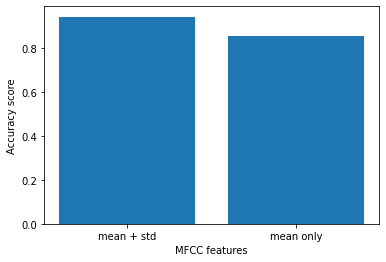

In [125]:
plt.bar(['mean + std', 'mean only'], [0.944547134935305, 0.8567467652495379] )
plt.ylabel('Accuracy score')
plt.xlabel('MFCC features')
plt.show()

In [126]:
print('Classification Report for K-nearest neighbor classifier with k = 10: \n',
      classification_report(y_val_test, y_pred_full_knn))

Classification Report for K-nearest neighbor classifier with k = 10: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       532
           1       0.97      0.92      0.94       550

    accuracy                           0.94      1082
   macro avg       0.95      0.94      0.94      1082
weighted avg       0.95      0.94      0.94      1082



**Conclusion from KNN model tests** 

From the plot shown above, we can see that the variability of the MFCC features captured in the standard deviation is informative for this task. Actually it improves the classification accuracy by over **10%**. As a result, all further tests are conducted using **mean + standard deviation** features.

###### Gaussian Naive Bayes

In [127]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)



GaussianNB(priors=None, var_smoothing=1e-09)

In [128]:
y_pred_gnb = gnb.predict(X_val_test_scaled)
test_score_gnb = accuracy_score(y_val_test, y_pred_gnb)
print(f'The accuracy of Gaussian Naive Bayes on the test data (MFCC mean + std) is: \n {test_score_gnb}')
print('=======================================================================================')
print('Classification Report for Naiva Bayes classifier: \n',
      classification_report(y_val_test, y_pred_gnb))

The accuracy of Gaussian Naive Bayes on the test data (MFCC mean + std) is: 
 0.8271719038817006
Classification Report for Naiva Bayes classifier: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       532
           1       0.85      0.80      0.83       550

    accuracy                           0.83      1082
   macro avg       0.83      0.83      0.83      1082
weighted avg       0.83      0.83      0.83      1082



###### Random Forest Classifier

For the random forest classifier, I conduct a grid search for the optimal number of trees `n_estimators` and maximum tree depth `max_depth`. The best model whcih is fitted with the best parameters is then evaluated.

Also, I used the `feature importances` in random forest to explain the contribution of each feature (mean and std features) to the model.

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipeline = Pipeline([('rf', RandomForestClassifier())])

params = {'rf__n_estimators': [50, 300],
        'rf__max_depth': [30, 100],
         'rf__random_state': [RANDOM_SEED]}


In [130]:
rf_grid_search = GridSearchCV(rf_pipeline, param_grid= params, scoring= 'f1', cv = 3)
rf_grid_search.fit(X_train_scaled, y_train)

print(rf_grid_search.best_params_)

{'rf__max_depth': 30, 'rf__n_estimators': 300, 'rf__random_state': 42}


In [131]:
y_pred_rf = rf_grid_search.predict(X_val_test_scaled)
test_score_rf = accuracy_score(y_val_test, y_pred_rf)
print(f'The accuracy of RF on the test data (MFCC mean + std) is: \n {test_score_rf}')
print('=======================================================================================')
print('Classification Report for Random Forest: \n',
      classification_report(y_val_test, y_pred_rf))

The accuracy of RF on the test data (MFCC mean + std) is: 
 0.9048059149722736
Classification Report for Random Forest: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       532
           1       0.93      0.88      0.90       550

    accuracy                           0.90      1082
   macro avg       0.91      0.91      0.90      1082
weighted avg       0.91      0.90      0.90      1082



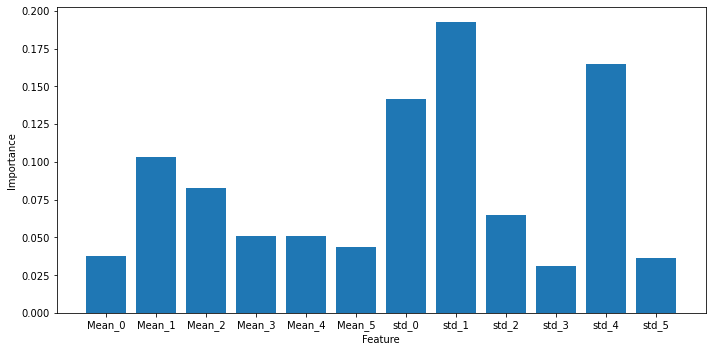

In [132]:
feature_importances_rf = rf_grid_search.best_estimator_.steps[0][1].feature_importances_
feature_names = ['Mean_' + str(n) if n < 6 else 'std_' + str(n-6) for n in range(12)]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, feature_importances_rf)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

From the figure above, indeed we can see that the variability information provided by the standard deviation are more informative than the mean information.


Below, the three classifiers fitted so far (GNB, RF and KNN) are compared in a bar plot

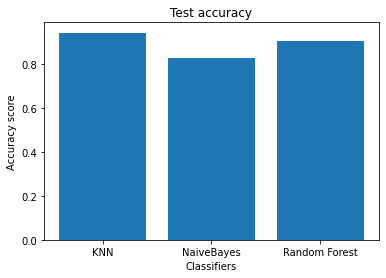

In [133]:
plt.bar(['KNN', 'NaiveBayes', 'Random Forest'], [0.944547134935305, 0.8271719038817006, 0.9048059149722736] )
plt.ylabel('Accuracy score')
plt.xlabel('Classifiers')
plt.title('Test accuracy')
plt.show()

Luckily, k-Nearest Neigbor (kNN), which is a relatively easy-to-train classifier produces the best result here. Complex is not always better. Feature engineering is the key. 

Also of note, Random forest helps us to understand the interaction between the MFCC features and the gender through the features ranking which has been plotted above. More optimization on the random forest model can be performed using the RF features ranking socre to drop uninformative features.

## Neural Networks


#### - Feed Forward Neural Network (NN)

In [134]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping

In [135]:
def feed_forward_NN():
    model = Sequential([
              Dense(64, input_dim= X_train_scaled.shape[1], activation='relu'),
              Dropout(.2),
              Dense(1, activation = 'sigmoid')
            ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

model = feed_forward_NN()


              
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                832       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [136]:

history = model.fit(X_train_scaled, y_train,
          batch_size= 32, validation_data= [X_val_scaled, y_val],
          epochs=100, verbose=2)

Train on 1621 samples, validate on 541 samples
Epoch 1/100
 - 0s - loss: 0.6055 - accuracy: 0.6848 - val_loss: 0.4901 - val_accuracy: 0.7967
Epoch 2/100
 - 0s - loss: 0.4264 - accuracy: 0.8415 - val_loss: 0.3975 - val_accuracy: 0.8226
Epoch 3/100
 - 0s - loss: 0.3559 - accuracy: 0.8606 - val_loss: 0.3550 - val_accuracy: 0.8429
Epoch 4/100
 - 0s - loss: 0.3227 - accuracy: 0.8680 - val_loss: 0.3293 - val_accuracy: 0.8521
Epoch 5/100
 - 0s - loss: 0.2926 - accuracy: 0.8754 - val_loss: 0.3103 - val_accuracy: 0.8558
Epoch 6/100
 - 0s - loss: 0.2761 - accuracy: 0.8853 - val_loss: 0.2961 - val_accuracy: 0.8651
Epoch 7/100
 - 0s - loss: 0.2647 - accuracy: 0.8914 - val_loss: 0.2847 - val_accuracy: 0.8688
Epoch 8/100
 - 0s - loss: 0.2460 - accuracy: 0.8994 - val_loss: 0.2754 - val_accuracy: 0.8725
Epoch 9/100
 - 0s - loss: 0.2365 - accuracy: 0.8994 - val_loss: 0.2662 - val_accuracy: 0.8743
Epoch 10/100
 - 0s - loss: 0.2306 - accuracy: 0.9038 - val_loss: 0.2588 - val_accuracy: 0.8780
Epoch 11/100

Epoch 87/100
 - 0s - loss: 0.1082 - accuracy: 0.9587 - val_loss: 0.1584 - val_accuracy: 0.9427
Epoch 88/100
 - 0s - loss: 0.0994 - accuracy: 0.9642 - val_loss: 0.1571 - val_accuracy: 0.9372
Epoch 89/100
 - 0s - loss: 0.1037 - accuracy: 0.9574 - val_loss: 0.1542 - val_accuracy: 0.9409
Epoch 90/100
 - 0s - loss: 0.0986 - accuracy: 0.9581 - val_loss: 0.1555 - val_accuracy: 0.9390
Epoch 91/100
 - 0s - loss: 0.0977 - accuracy: 0.9655 - val_loss: 0.1541 - val_accuracy: 0.9464
Epoch 92/100
 - 0s - loss: 0.0970 - accuracy: 0.9636 - val_loss: 0.1540 - val_accuracy: 0.9409
Epoch 93/100
 - 0s - loss: 0.0954 - accuracy: 0.9618 - val_loss: 0.1539 - val_accuracy: 0.9445
Epoch 94/100
 - 0s - loss: 0.0999 - accuracy: 0.9599 - val_loss: 0.1535 - val_accuracy: 0.9427
Epoch 95/100
 - 0s - loss: 0.0982 - accuracy: 0.9667 - val_loss: 0.1536 - val_accuracy: 0.9427
Epoch 96/100
 - 0s - loss: 0.0971 - accuracy: 0.9624 - val_loss: 0.1549 - val_accuracy: 0.9427
Epoch 97/100
 - 0s - loss: 0.0991 - accuracy: 0.96

In [145]:
y_pred_feed_forward = model.predict_classes(X_test_scaled)
test_score_feed_forward = accuracy_score(y_test, y_pred_feed_forward)
print(f'The accuracy of Feed foward NN on the test data (MFCC mean + std) is: \n {test_score_feed_forward}')
print('=======================================================================================')
print('Classification Report for Feed foward NN: \n',
      classification_report(y_test, y_pred_feed_forward))

The accuracy of Feed foward NN on the test data (MFCC mean + std) is: 
 0.9408502772643254
Classification Report for Feed foward NN: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       266
           1       0.95      0.93      0.94       275

    accuracy                           0.94       541
   macro avg       0.94      0.94      0.94       541
weighted avg       0.94      0.94      0.94       541



<function matplotlib.pyplot.show(*args, **kw)>

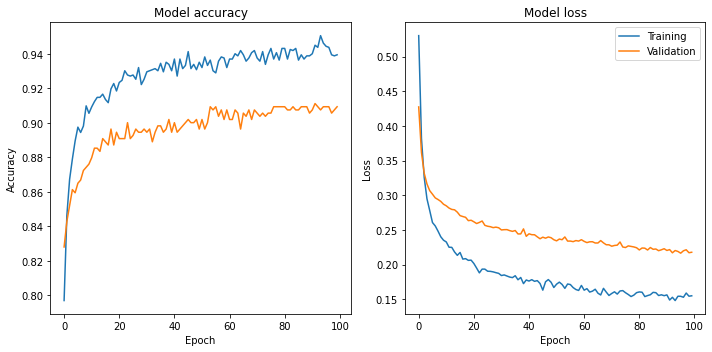

In [165]:
fig, [ax1, ax2] = plt.subplots(nrows= 1, ncols= 2, figsize = (10, 5))
ax1.plot(history.history['accuracy'], label = 'Training')
ax1.plot(history.history['val_accuracy'], label = 'Validation')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.plot(history.history['loss'], label = 'Training')
ax2.plot(history.history['val_loss'], label = 'Validation')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show

##### Convolutional neural network (CNN)

In [156]:
def CNN():
    model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
            Dropout(0.2),
            Flatten(),
            Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


model_cnn = CNN()


              
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 10, 64)            256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 641       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [157]:
X_train_scaled_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)

history_cnn = model_cnn.fit(X_train_scaled_cnn, y_train,
          batch_size= 32, validation_data= [X_val_scaled_cnn, y_val],
          epochs=100, verbose=2)

Train on 1621 samples, validate on 541 samples
Epoch 1/100
 - 1s - loss: 0.5588 - accuracy: 0.7822 - val_loss: 0.4470 - val_accuracy: 0.8189
Epoch 2/100
 - 0s - loss: 0.3906 - accuracy: 0.8513 - val_loss: 0.3653 - val_accuracy: 0.8410
Epoch 3/100
 - 0s - loss: 0.3282 - accuracy: 0.8735 - val_loss: 0.3314 - val_accuracy: 0.8595
Epoch 4/100
 - 0s - loss: 0.2952 - accuracy: 0.8816 - val_loss: 0.3173 - val_accuracy: 0.8558
Epoch 5/100
 - 0s - loss: 0.2748 - accuracy: 0.8859 - val_loss: 0.3047 - val_accuracy: 0.8632
Epoch 6/100
 - 0s - loss: 0.2627 - accuracy: 0.8970 - val_loss: 0.2986 - val_accuracy: 0.8651
Epoch 7/100
 - 0s - loss: 0.2537 - accuracy: 0.9007 - val_loss: 0.2952 - val_accuracy: 0.8632
Epoch 8/100
 - 0s - loss: 0.2469 - accuracy: 0.9050 - val_loss: 0.2906 - val_accuracy: 0.8743
Epoch 9/100
 - 0s - loss: 0.2415 - accuracy: 0.9050 - val_loss: 0.2887 - val_accuracy: 0.8780
Epoch 10/100
 - 0s - loss: 0.2345 - accuracy: 0.9044 - val_loss: 0.2830 - val_accuracy: 0.8835
Epoch 11/100

Epoch 87/100
 - 0s - loss: 0.1506 - accuracy: 0.9414 - val_loss: 0.2194 - val_accuracy: 0.9039
Epoch 88/100
 - 0s - loss: 0.1533 - accuracy: 0.9420 - val_loss: 0.2196 - val_accuracy: 0.9057
Epoch 89/100
 - 0s - loss: 0.1532 - accuracy: 0.9432 - val_loss: 0.2206 - val_accuracy: 0.9057
Epoch 90/100
 - 0s - loss: 0.1509 - accuracy: 0.9420 - val_loss: 0.2198 - val_accuracy: 0.9057
Epoch 91/100
 - 0s - loss: 0.1509 - accuracy: 0.9402 - val_loss: 0.2212 - val_accuracy: 0.9002
Epoch 92/100
 - 0s - loss: 0.1484 - accuracy: 0.9463 - val_loss: 0.2228 - val_accuracy: 0.9057
Epoch 93/100
 - 0s - loss: 0.1494 - accuracy: 0.9408 - val_loss: 0.2221 - val_accuracy: 0.9076
Epoch 94/100
 - 0s - loss: 0.1501 - accuracy: 0.9408 - val_loss: 0.2197 - val_accuracy: 0.9002
Epoch 95/100
 - 0s - loss: 0.1487 - accuracy: 0.9389 - val_loss: 0.2192 - val_accuracy: 0.9002
Epoch 96/100
 - 0s - loss: 0.1555 - accuracy: 0.9408 - val_loss: 0.2192 - val_accuracy: 0.9002
Epoch 97/100
 - 0s - loss: 0.1528 - accuracy: 0.94

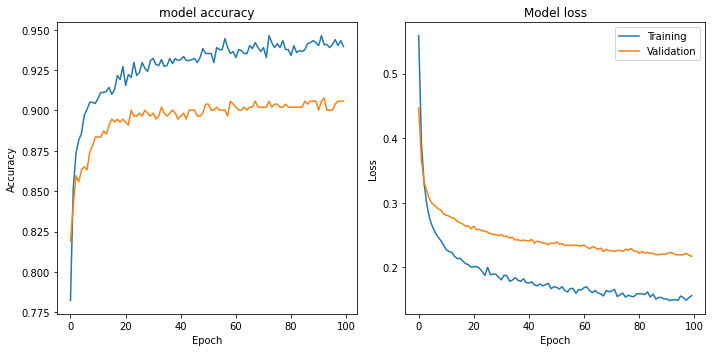

In [166]:
fig, [ax1, ax2] = plt.subplots(nrows= 1, ncols= 2, figsize = (10, 5))
ax1.plot(history_cnn.history['accuracy'], label = 'Training')
ax1.plot(history_cnn.history['val_accuracy'], label = 'Validation')
ax1.set_title('model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.plot(history_cnn.history['loss'], label = 'Training')
ax2.plot(history_cnn.history['val_loss'], label = 'Validation')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Since the loss is not oscilating and always descending, more epochs can actually improve the model performance. Also, early stopping can be used to obtain the bet model among all the epochs.**

In [167]:
X_test_scaled_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
y_pred_cnn = model_cnn.predict_classes(X_test_scaled_cnn)
test_score_cnn = accuracy_score(y_test, y_pred_cnn)
print(f'The accuracy of CNN on the test data (MFCC mean + std) is: \n {test_score_cnn}')
print('=======================================================================================')
print('Classification Report for CNN: \n',
      classification_report(y_test, y_pred_cnn))

The accuracy of CNN on the test data (MFCC mean + std) is: 
 0.88909426987061
Classification Report for CNN: 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       266
           1       0.91      0.87      0.89       275

    accuracy                           0.89       541
   macro avg       0.89      0.89      0.89       541
weighted avg       0.89      0.89      0.89       541



**RESULTS TABLE**

| Model | Test Accuracy |
|-------|----------|
| k-Nearest Neighbor   | 0.9445   |
| Naive bayes   | 0.8272  |
| Random Forest  | 0.9048  |
| Feed forward NN  | 0.9408  |
| Convolutional NN | 0.8891  |


From this table, we can see that KNN performs better in accuracy and Naive Bayes produces the worst accuracy.


# CONCLUSION

The major highlight of this work is the feature engineering. And the major results are:
- By selecting only the first 6 MFCC features and contenating theirs means and standard deviation, we derive a feature with which we can classify gender speaches effectively, based on the data used for this study.
- The feature engineering used in this task, which reduces the dimensionality of the data by a lot, is able to achieve high accuracy.
- Specifically, the obtained feature is able to achieve 94% accuracy with a simple clasifier such a k-Nearest Neighbor. For the other classifiers (especially neural network), there is the possibility to get better results if rigorous hyperparameter tuning is performed.
- Looking at the results presented in the feature importances plot based in Random Forest, it is possible to see that the MFCC features standard deviation are informative. Specifically, the top 3 most informative features are standard deviation features.

Thanks for this task, even though I was only able to dedicate 7 hours to it, I indeed enjoyed it. Hope I sail through the round and meet you guys soon.